In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"

import jax.numpy as np
import matplotlib.pyplot as plt
from jax import random
from nrmifactors import algorithm as algo

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

# UPDATE OF CLUSTER PARAMETERS

In [2]:
key = random.PRNGKey(0)

means = np.array([-10.0, 0.0, 10.0])
probas = np.ones(3) / 3

key, subkey = random.split(key)
clus = tfd.Categorical(probs=probas).sample((3, 50), seed=subkey)
data = tfd.Normal(means[clus], np.ones_like(clus, dtype=float)).sample(seed=subkey)

In [3]:
from nrmifactors.priors import NNIGPrior

prior = NNIGPrior(0.0, 0.1, 10, 10)
atoms, key = algo.update_atoms(data, clus, prior, key)

In [4]:
atoms

DeviceArray([[-9.94757004,  0.78135447],
             [ 0.12600974,  1.11726241],
             [10.06306657,  2.266575  ]], dtype=float64)

# UPDATE OF J's

In [5]:
from nrmifactors.priors import GammaPrior

In [6]:
key, subkey = random.split(key)

ngroups = 10
nlat = 3
natoms = 20
ndata = 100

lam = tfd.Gamma(1.0, 1.0).sample((ngroups, nlat), seed=subkey)
m = tfd.Gamma(1.0, 1.0).sample((nlat, natoms), seed=subkey)
j = np.ones(natoms, dtype=float)

probas = np.matmul(lam, m) * j
T = probas.sum(axis=1)
probas /= probas.sum(axis=1)[:,None]
u = tfd.Gamma(np.ones(ngroups, dtype=float) * ndata, T).sample(seed=subkey)

clus = tfd.Categorical(probs=probas).sample(ndata, seed=subkey).T

prior = GammaPrior(1.0, 1.0)
jpost, key = algo.update_Js(clus, lam, m, u, prior, key)

float32
float64
float64
float64


# Update of Lambda

In [7]:
key, subkey = random.split(key)
prior = GammaPrior(1.0, 1.0)

post_lam = np.zeros((ngroups, nlat)) + 0.5

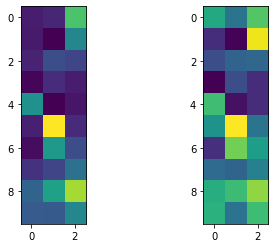

In [8]:
post_lam, key = algo.update_lambda(clus, post_lam, m, jpost, u, prior, key, 0.001, 50, 100)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(lam)
axes[1].imshow(post_lam)

# Update of M

In [9]:
key, subkey = random.split(key)
post_m = np.zeros_like(m, dtype=np.float64) + 0.01

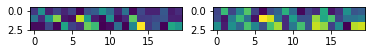

In [10]:
post_m, key = algo.update_m(clus, lam, post_m, jpost, u, prior, key, 0.001, 50, 100)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(m)
axes[1].imshow(post_m)

# Update of U

In [11]:
j.shape

(20,)

In [12]:
np.sum(np.matmul(lam, m) * j, axis=0).shape

(20,)

In [13]:
key, subkey = random.split(key)
post_u, key = algo.update_u(data, lam, m, j, key)

ValueError: Incompatible shapes for broadcasting: (3,) and (20,)

(3, 50)